In [1]:
%matplotlib inline


Neural Networks
===============

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

Define the network
------------------

Let’s define this network:



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #3 in 6 out
        self.conv1 = nn.Conv2d(3, 6, 5) #5x5 filter
        #pool output 2x2
        self.pool = nn.MaxPool2d(2, 2)
        #6 in 16 out
        self.conv2 = nn.Conv2d(6, 16, 5)#5x5 filter
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #reshape data from conv layer to linear layer
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



# load data

In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


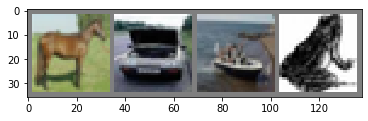

horse   car  ship  frog


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Training

In [6]:
criterion = nn.CrossEntropyLoss()

In [13]:
net = Net()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)
#stochastic gradient descent
#weight = weight - learning_rate * gradient

In [14]:
start = time.time()

for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): 
    #enumerate iterates over list, 
    #second parameter specifies starting index
        
        #get inputs for net; data is a list of [inputs, labels]
        inputs, labels = data
        
        #zero gradients each time
        optimizer.zero_grad()
        
        #forward prop
        output = net(inputs)
        
        #compute loss
        loss = criterion(output, labels)
        
        #backward prop
        loss.backward()
        
        #update weights
        optimizer.step()
        
        #print statistacs
        running_loss += loss.item()
        if i % 2000 == 1999: #print every 2000 mini-batches
                print('epoc {}, batch {} - loss: {:.4f}'.format(
                    epoch+1,
                    i+1,
                    running_loss/2000                    
                    ))
                running_loss = 0

end = time.time()
print("done, time: {}".format(end-start))

epoc 1, batch 2000 - loss: 2.1944
epoc 1, batch 4000 - loss: 1.9039
epoc 1, batch 6000 - loss: 1.7204
epoc 1, batch 8000 - loss: 1.5981
epoc 1, batch 10000 - loss: 1.5308
epoc 1, batch 12000 - loss: 1.4877
epoc 2, batch 2000 - loss: 1.4073
epoc 2, batch 4000 - loss: 1.3831
epoc 2, batch 6000 - loss: 1.3495
epoc 2, batch 8000 - loss: 1.3387
epoc 2, batch 10000 - loss: 1.3313
epoc 2, batch 12000 - loss: 1.2988
done, time: 113.26124668121338


# CUDA

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
torch.cuda.is_available()

GeForce GTX 960M


True

In [11]:
net2 = Net()
net2.to(device)
optimizer2 = optim.SGD(net2.parameters(), lr=0.001, momentum = 0.9)

In [12]:
start = time.time()

for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): 

        #cast to gpu
        inputs = data[0].to(device)
        labels = data[1].to(device)
        
        #use new optimiser
        optimizer2.zero_grad()
        
        #use casted net
        output = net2(inputs)
        
        loss = criterion(output, labels)
        loss.backward()
        
        #use new optimiser
        optimizer2.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
                print('epoc {}, batch {} - loss: {:.4f}'.format(
                    epoch+1,
                    i+1,
                    running_loss/2000                    
                    ))
                running_loss = 0

end = time.time()
print("done, time: {}".format(end-start))

epoc 1, batch 2000 - loss: 2.2210
epoc 1, batch 4000 - loss: 1.8726
epoc 1, batch 6000 - loss: 1.6765
epoc 1, batch 8000 - loss: 1.5732
epoc 1, batch 10000 - loss: 1.4979
epoc 1, batch 12000 - loss: 1.4525
epoc 2, batch 2000 - loss: 1.3987
epoc 2, batch 4000 - loss: 1.3850
epoc 2, batch 6000 - loss: 1.3453
epoc 2, batch 8000 - loss: 1.3374
epoc 2, batch 10000 - loss: 1.3049
epoc 2, batch 12000 - loss: 1.3004
done, time: 74.77279806137085


In [10]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**2,1), 'MB')

GeForce GTX 960M
Memory Usage:
Allocated: 0.2 MB
Cached:    2.0 MB


# Results (of net 1)

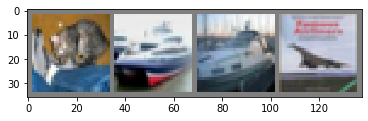

GroundTruth:    cat  ship  ship plane


In [37]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [38]:
outputs = net(images)
#print(outputs)

_, predicted = torch.max(outputs, 1) #1 indicates dimension
# get index of highest value in outputs

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [29]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 55 %
Accuracy of   car : 57 %
Accuracy of  bird : 42 %
Accuracy of   cat : 32 %
Accuracy of  deer : 34 %
Accuracy of   dog : 56 %
Accuracy of  frog : 64 %
Accuracy of horse : 72 %
Accuracy of  ship : 78 %
Accuracy of truck : 65 %


# Results (of net 2)

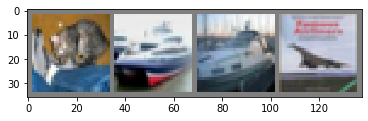

GroundTruth:    cat  ship  ship plane


In [31]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
outputs = net2(images.to(device))
#print(outputs)

_, predicted = torch.max(outputs, 1) #1 indicates dimension
# get index of highest value in outputs

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  horse   car  ship   cat


In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device),data[1].to(device)
        outputs = net2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device),data[1].to(device)
        outputs = net2(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 69 %
Accuracy of  bird : 36 %
Accuracy of   cat : 37 %
Accuracy of  deer : 35 %
Accuracy of   dog : 61 %
Accuracy of  frog : 64 %
Accuracy of horse : 46 %
Accuracy of  ship : 65 %
Accuracy of truck : 69 %
